In [12]:
import pandas as pd

df = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\features.csv")
y = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\labels.csv").to_numpy().flatten()

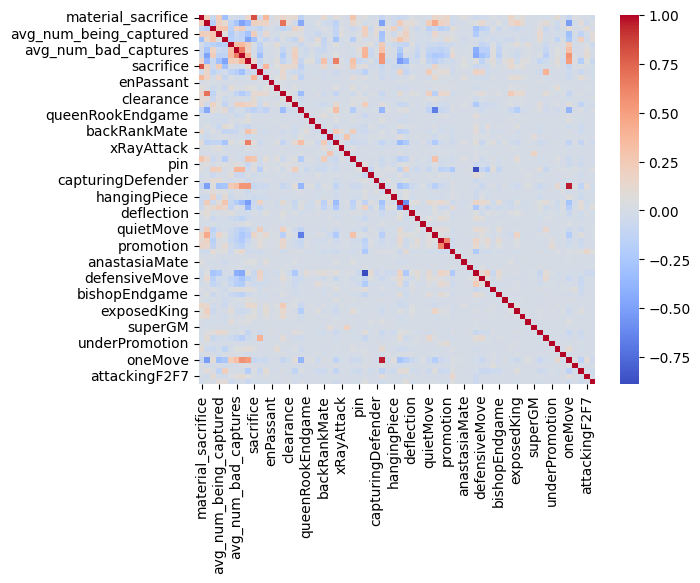

               Feature 1             Feature 2  Correlation
29               oneMove               mateIn1     0.960276
25               endgame            middlegame     0.889491
0     material_sacrifice             sacrifice     0.821521
1          puzzle_length              veryLong     0.693901
13                 short                  long     0.670998
7                   mate               mateIn2     0.642290
3   avg_num_bad_captures  avg_branching_factor     0.641103
23          advancedPawn             promotion     0.603967
20              crushing             advantage     0.583281
6   avg_branching_factor               oneMove     0.563821
8                   mate               mateIn1     0.545983
16               mateIn1  avg_branching_factor     0.545284
9                   mate              crushing     0.526234
2          puzzle_length               oneMove     0.519801
10                  mate               oneMove     0.514596


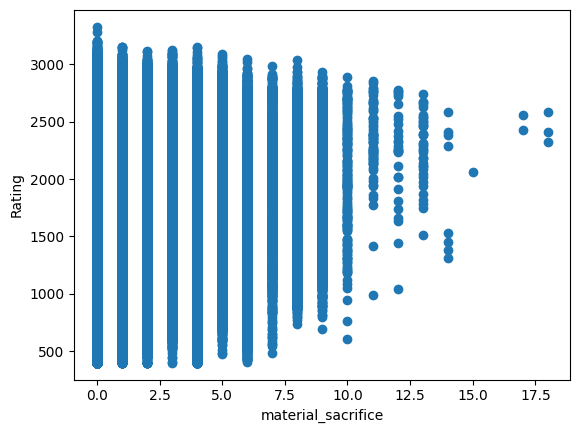

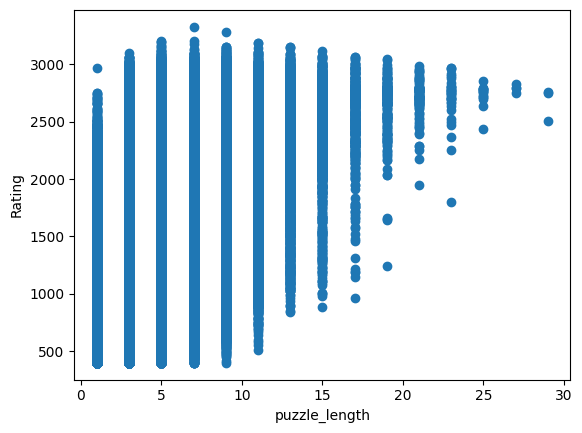

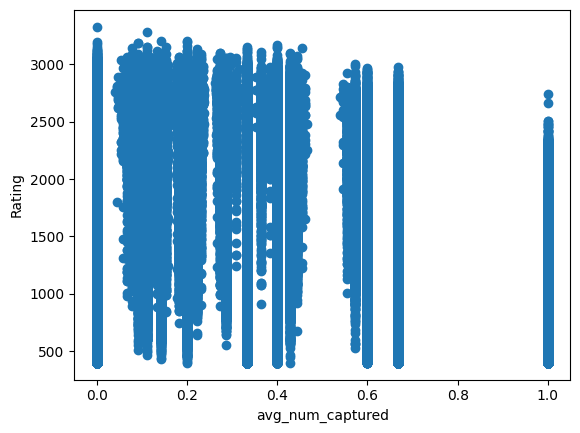

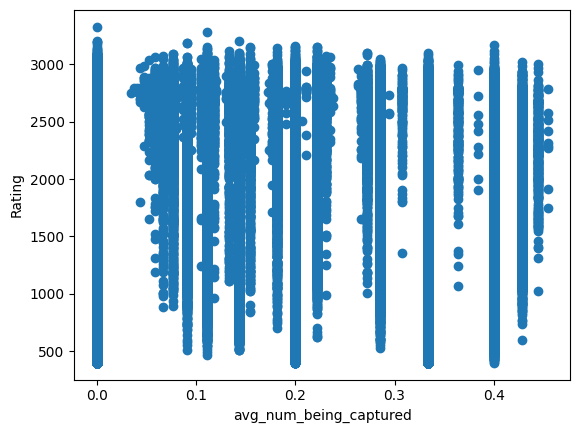

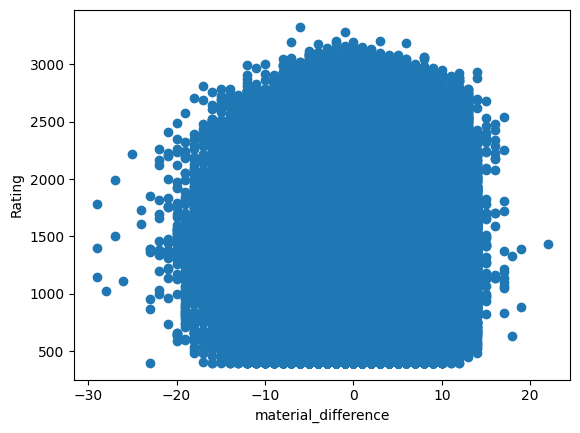

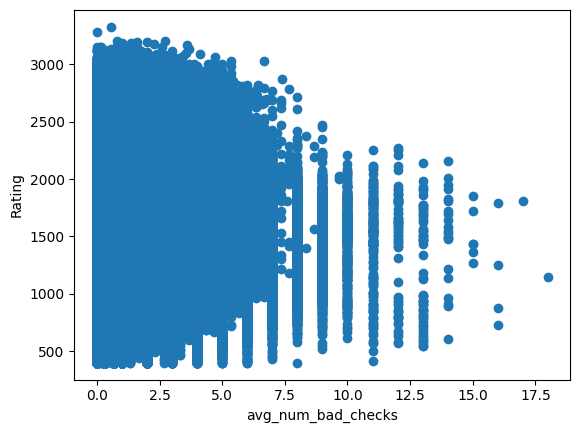

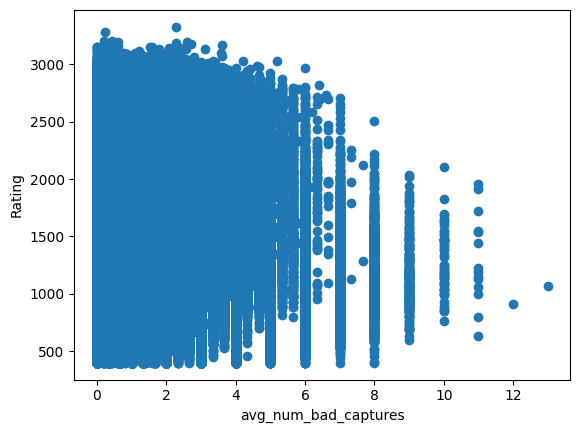

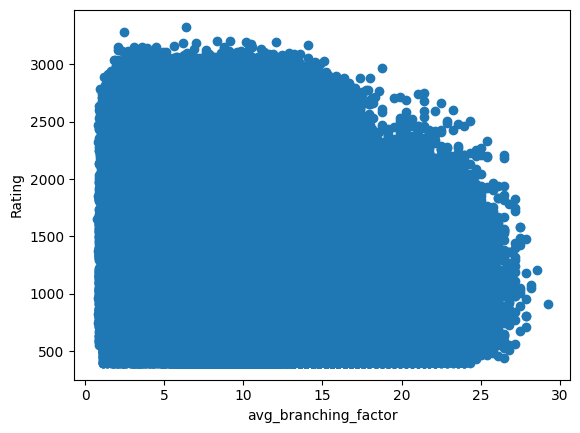

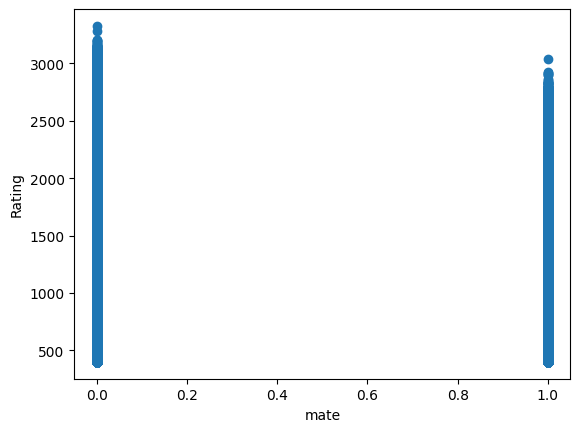

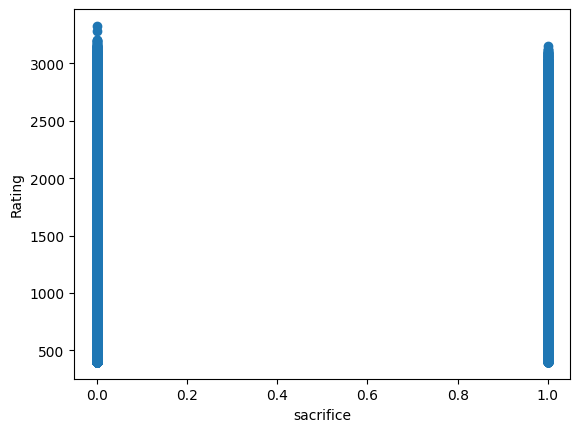

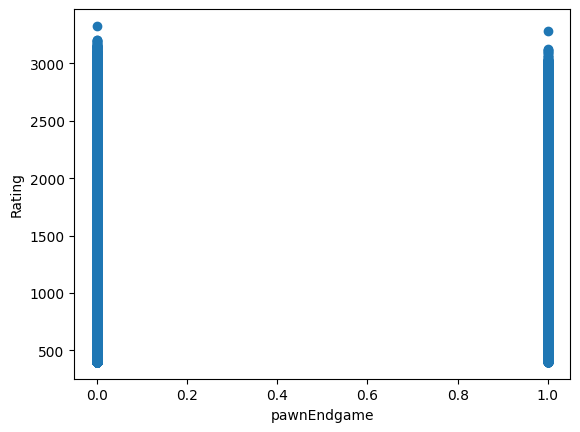

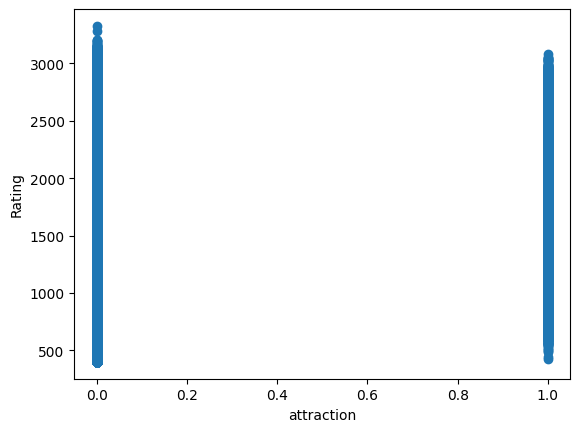

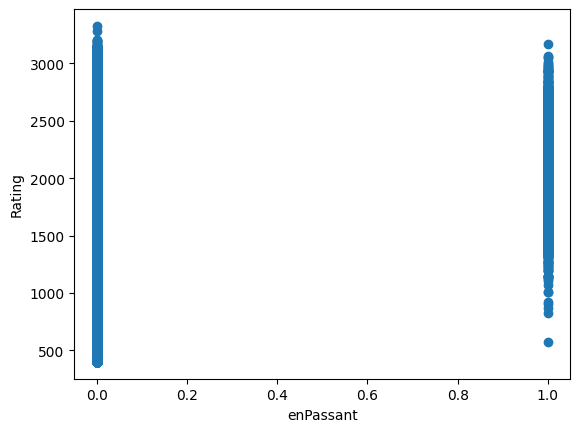

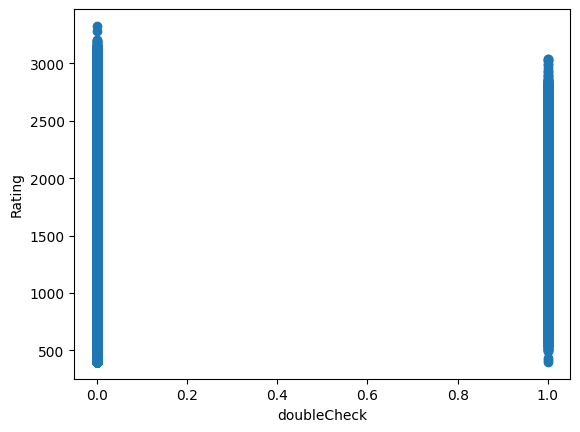

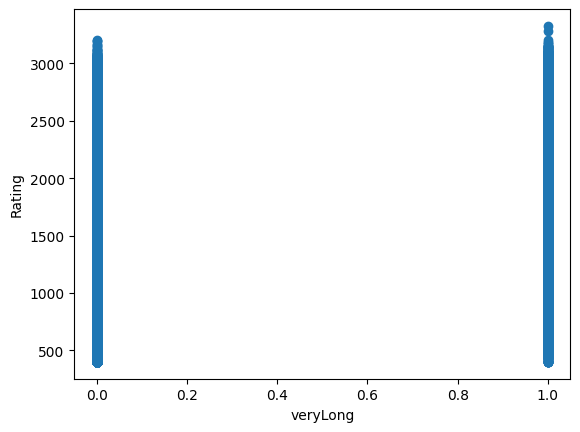

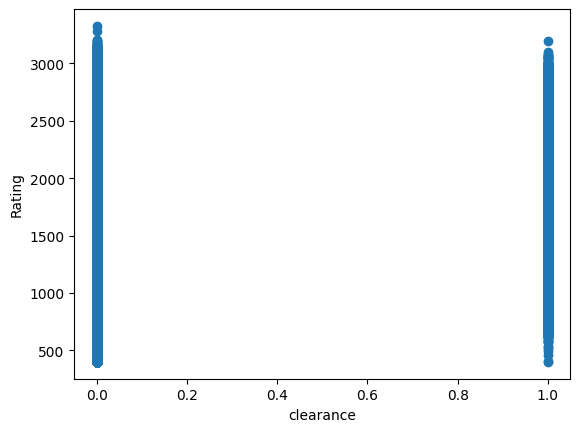

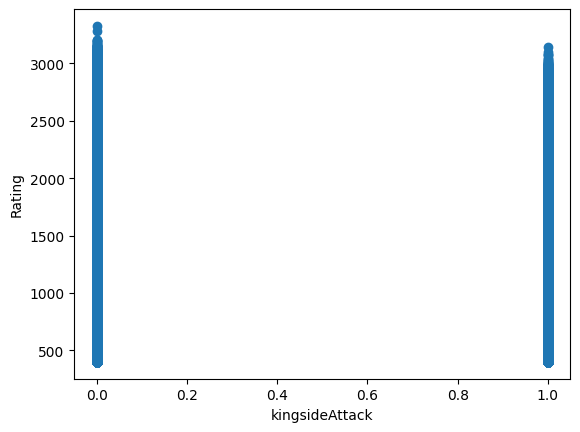

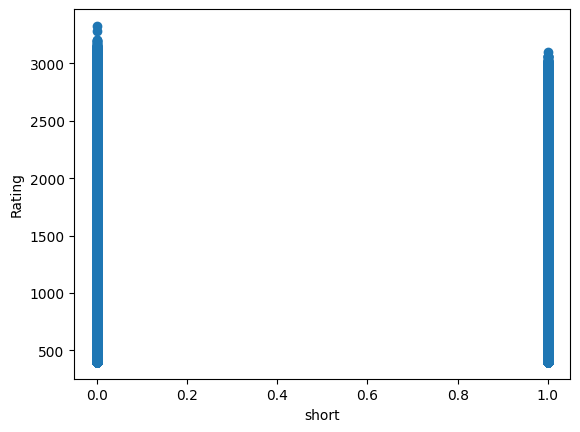

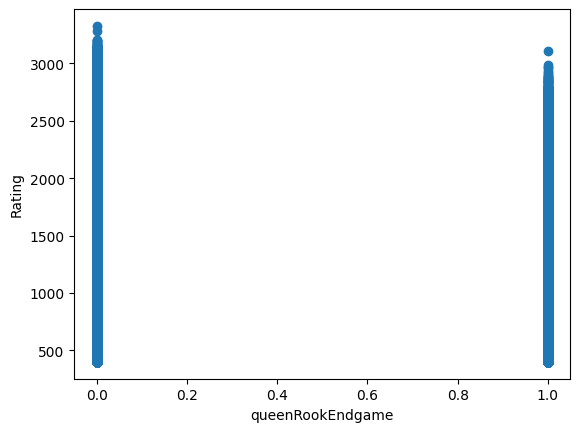

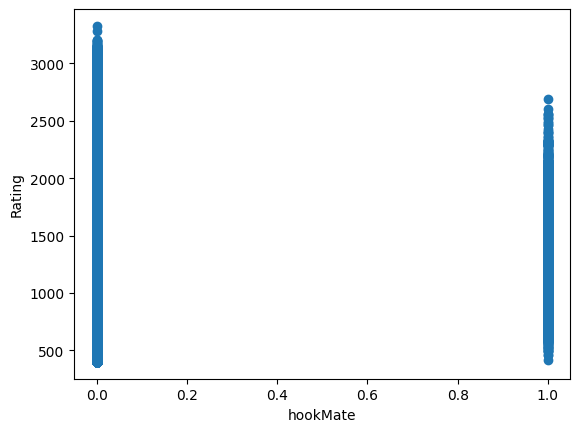

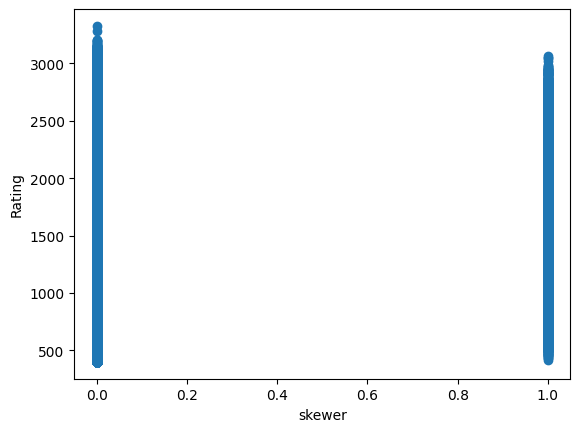

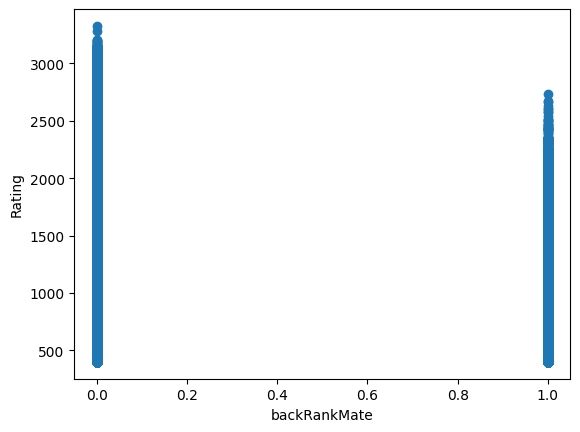

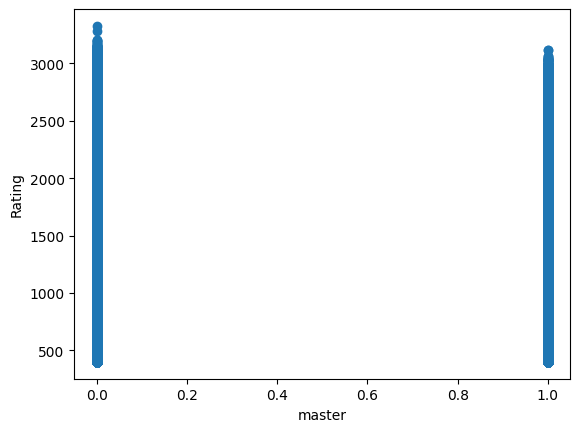

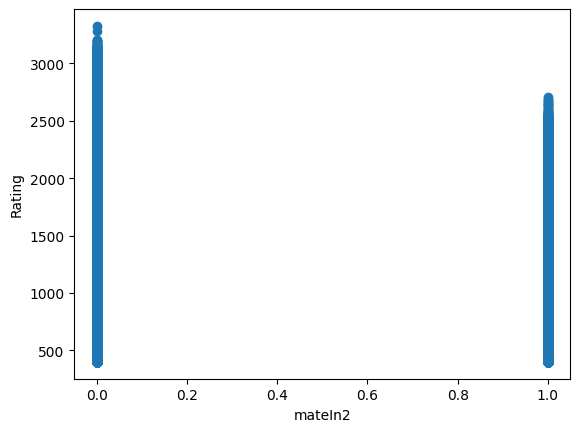

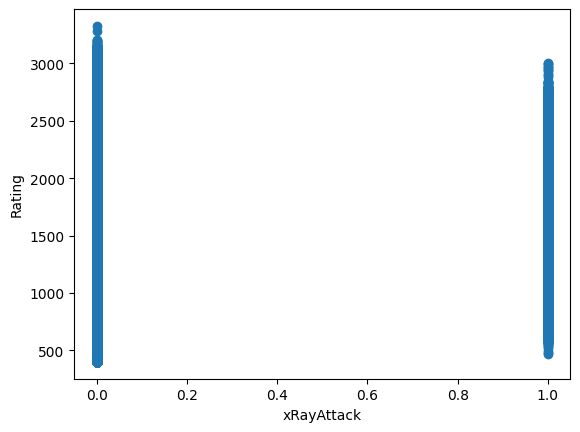

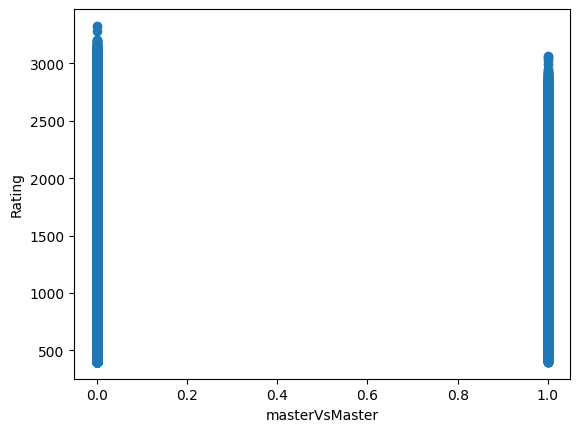

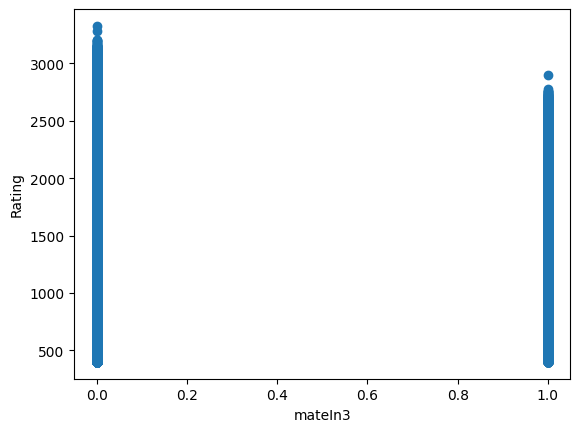

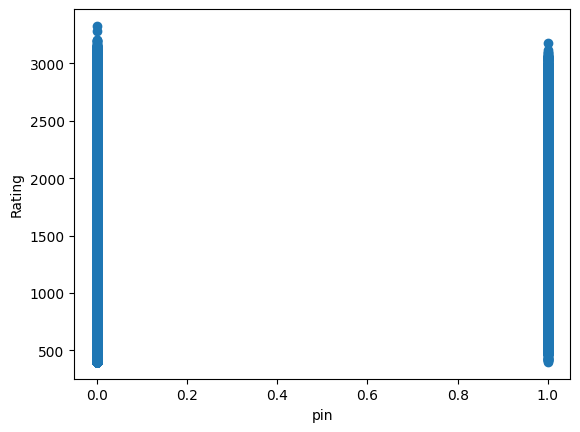

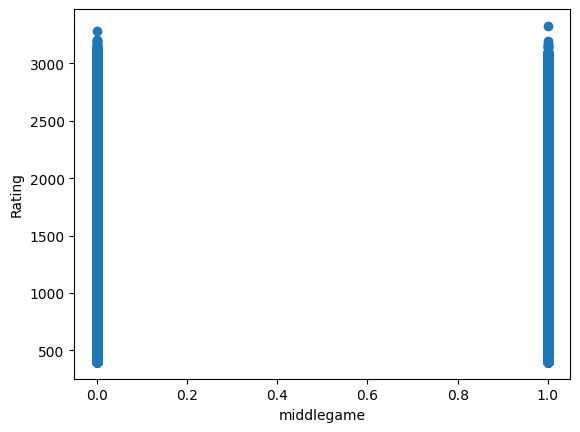

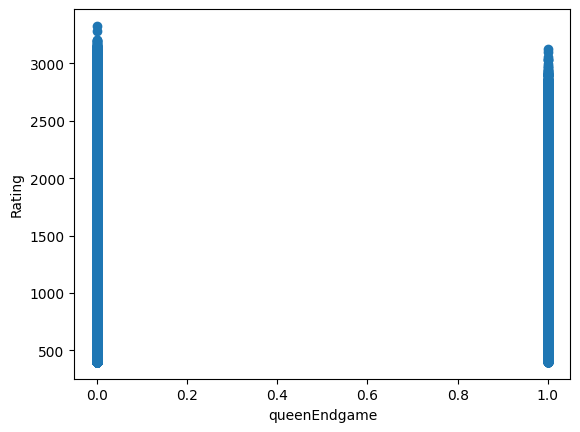

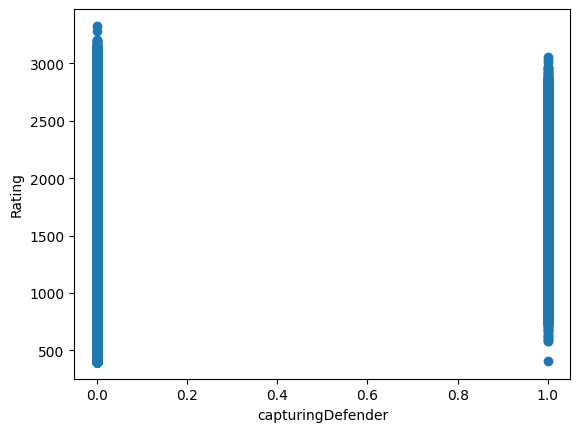

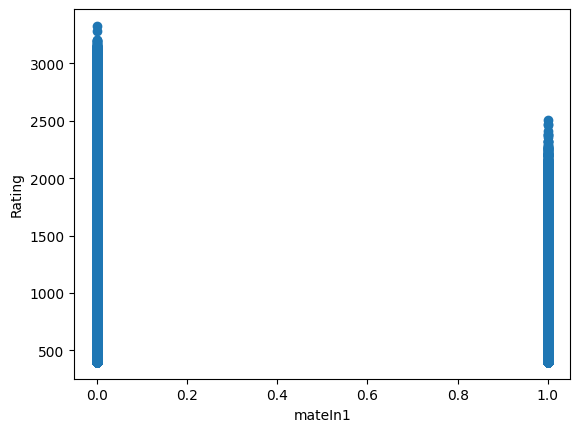

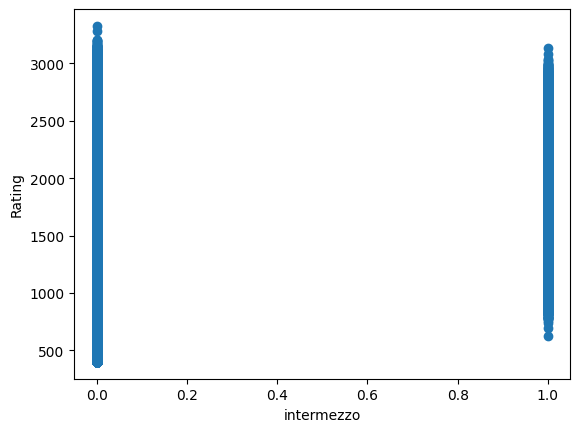

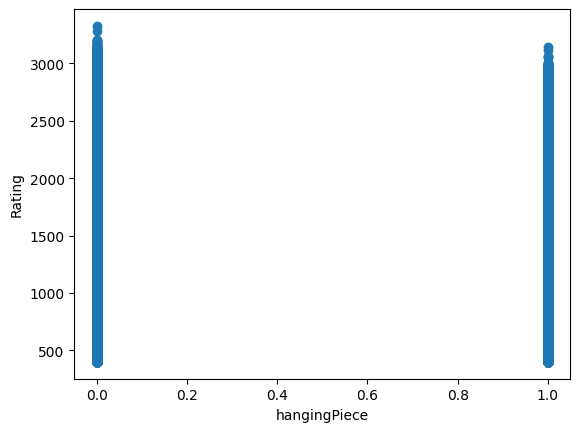

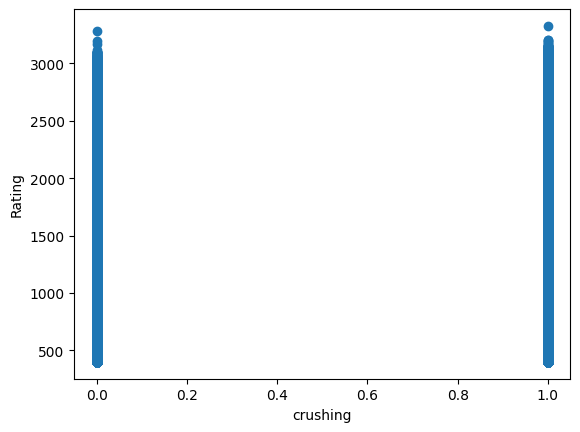

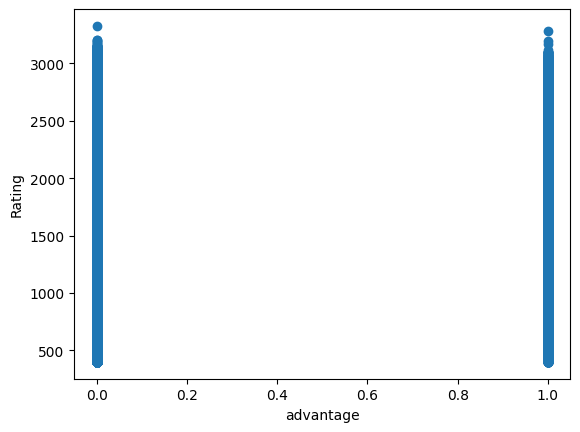

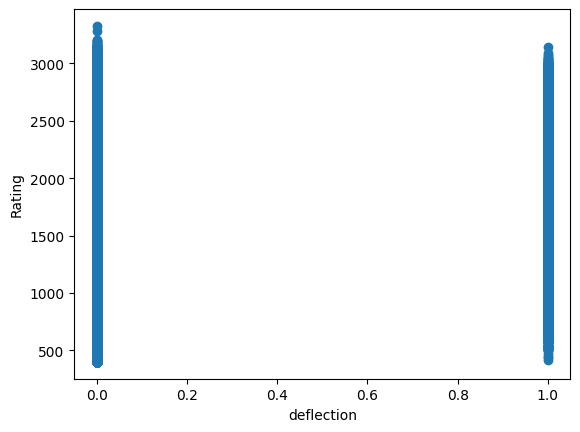

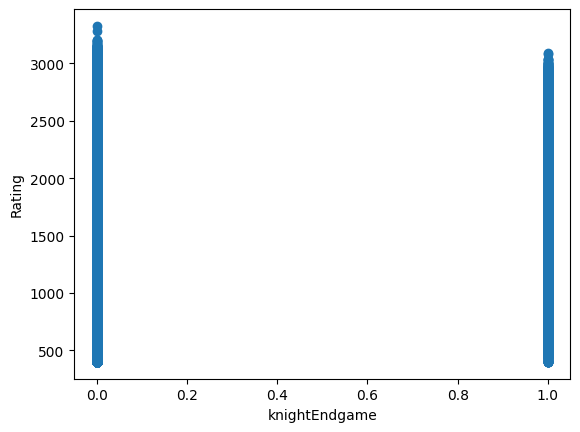

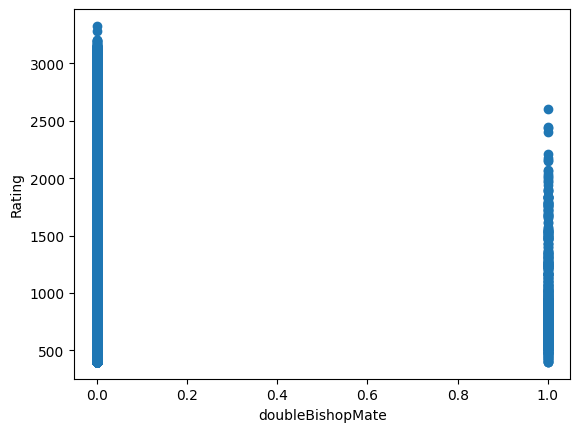

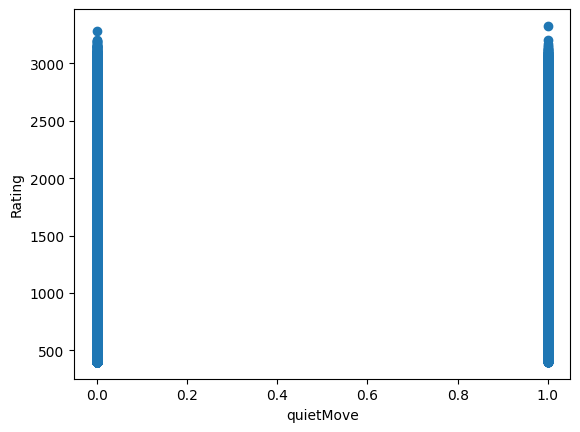

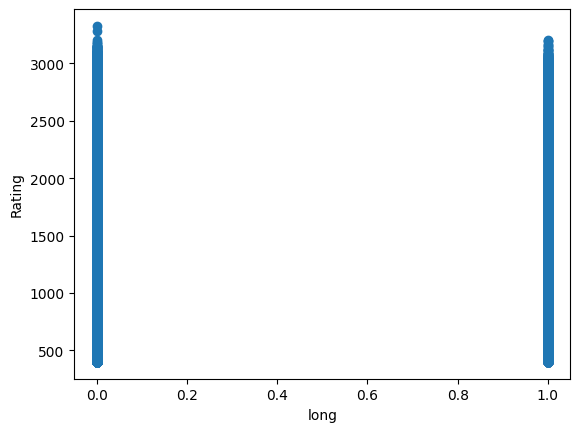

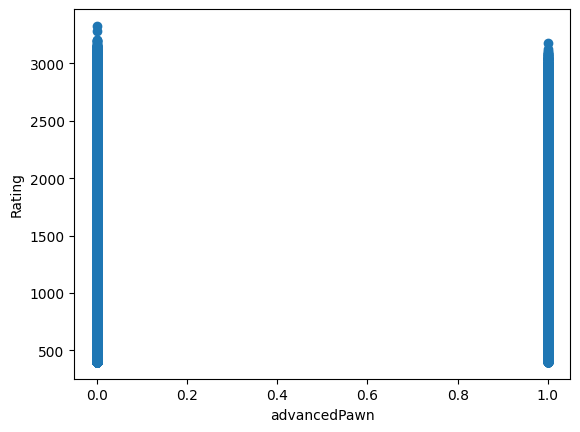

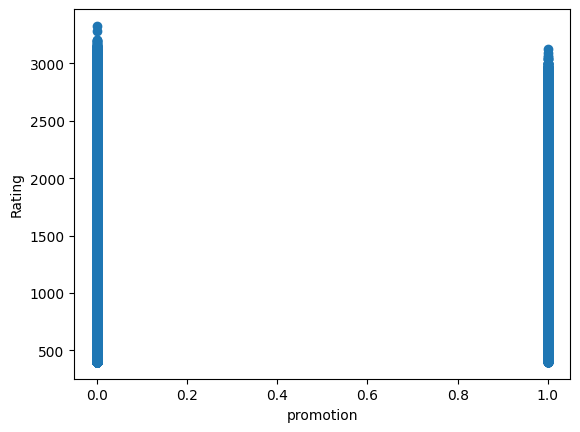

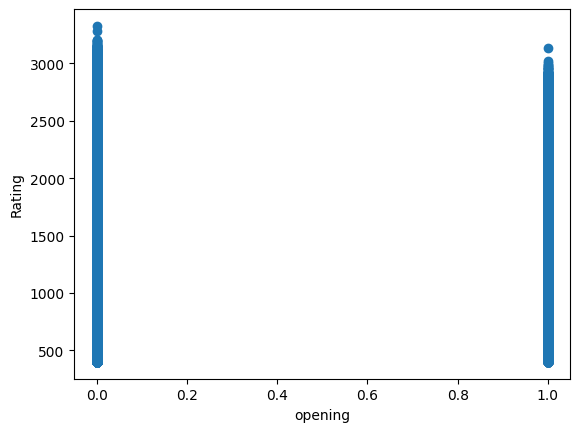

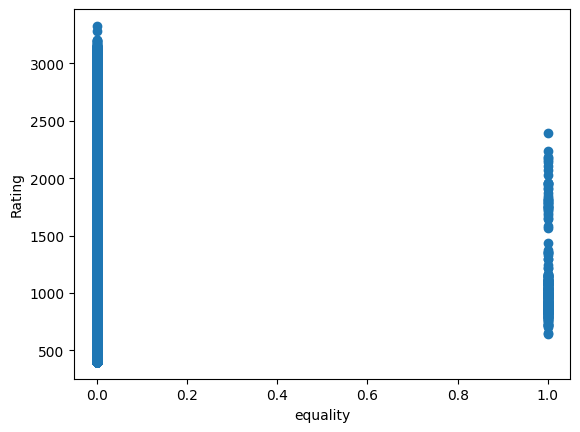

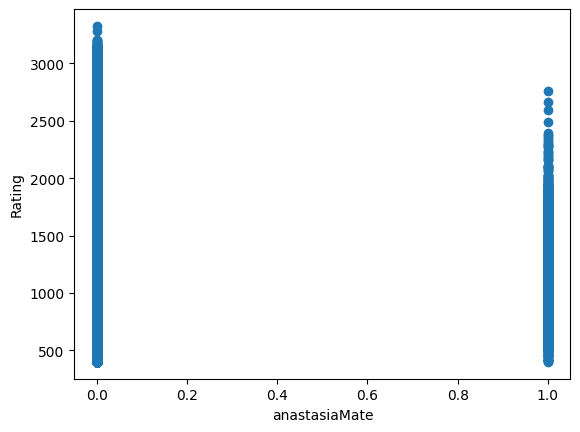

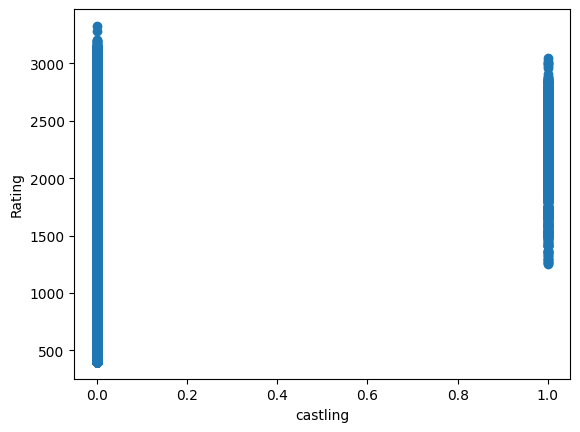

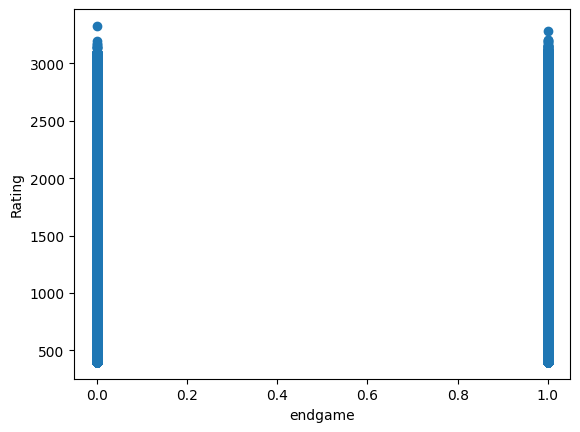

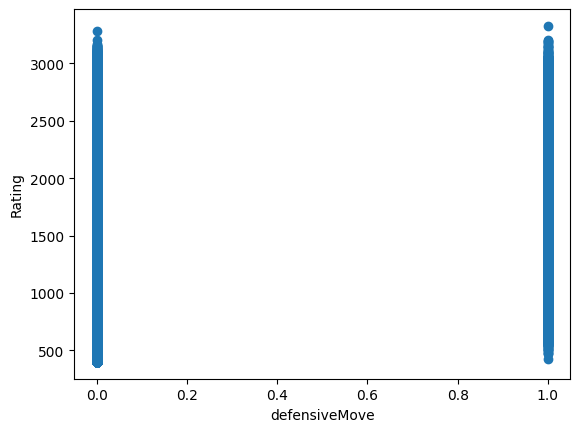

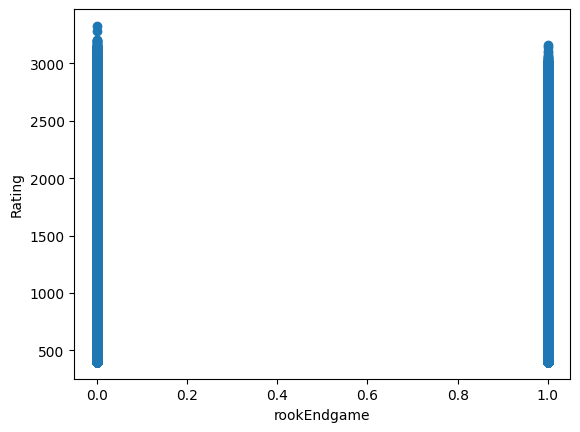

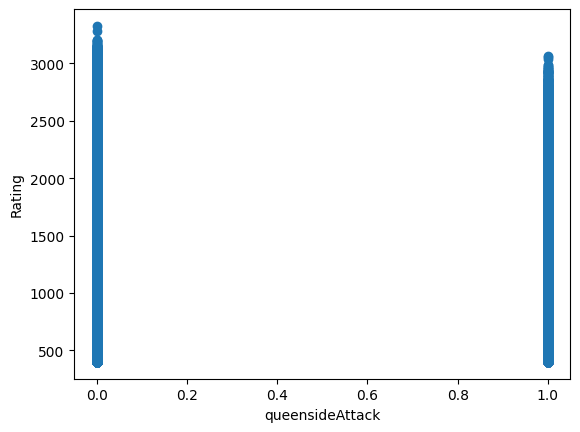

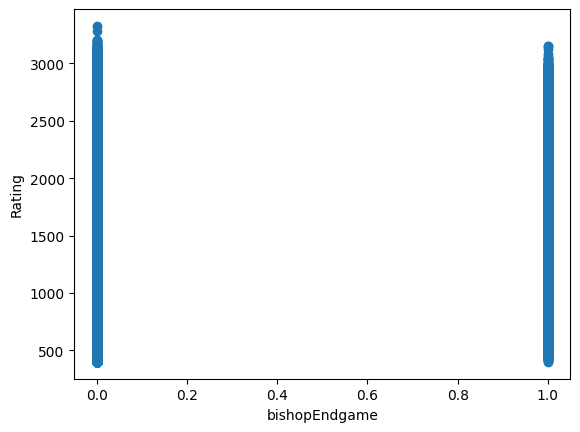

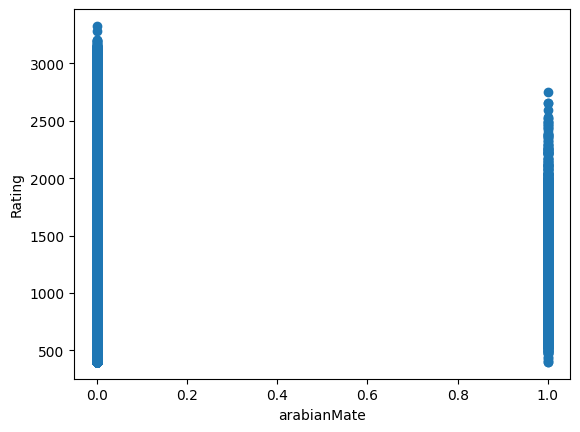

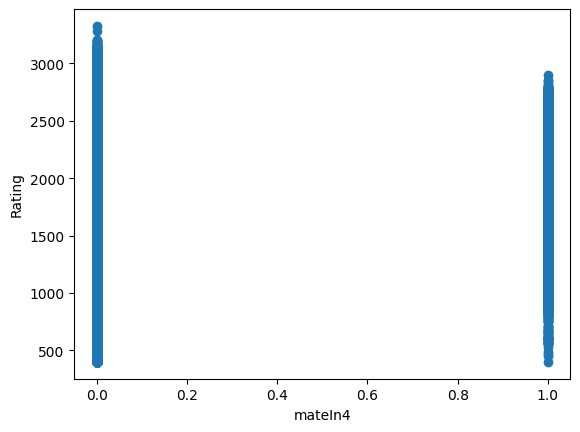

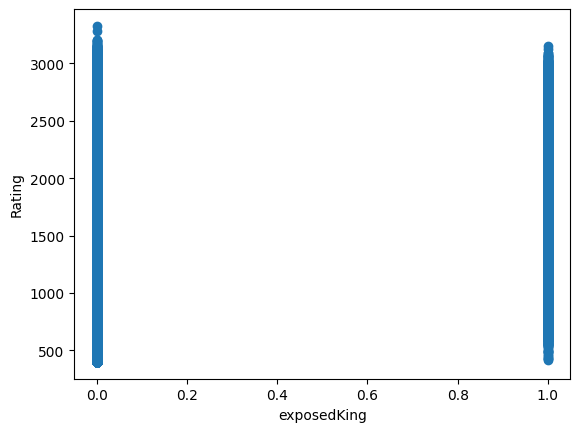

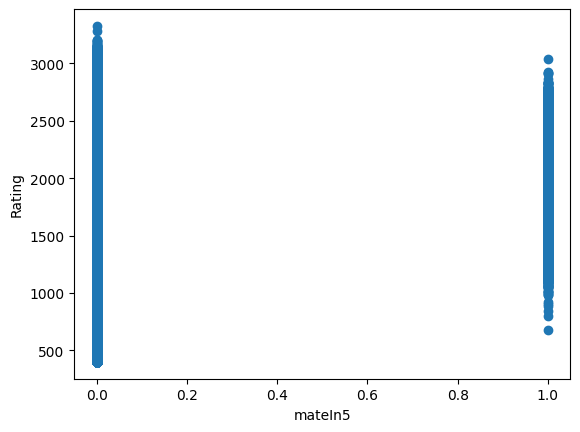

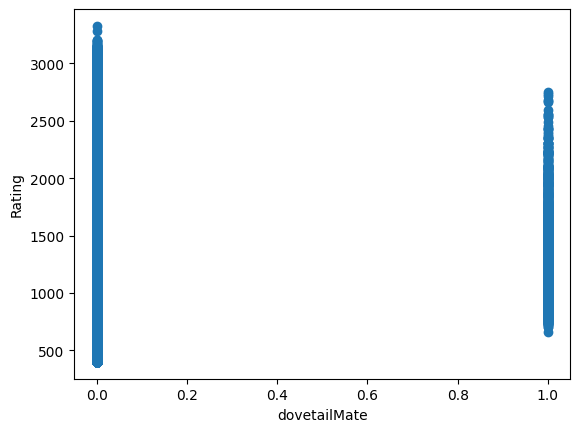

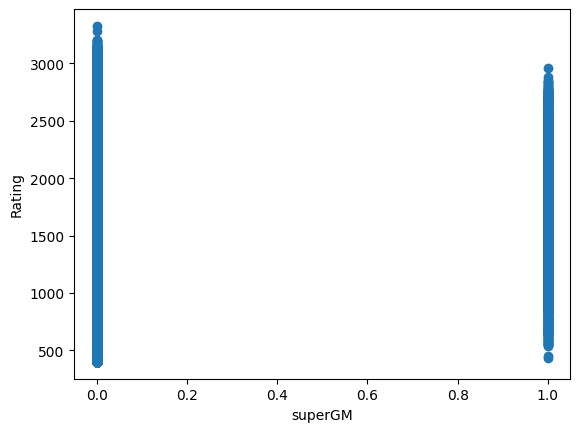

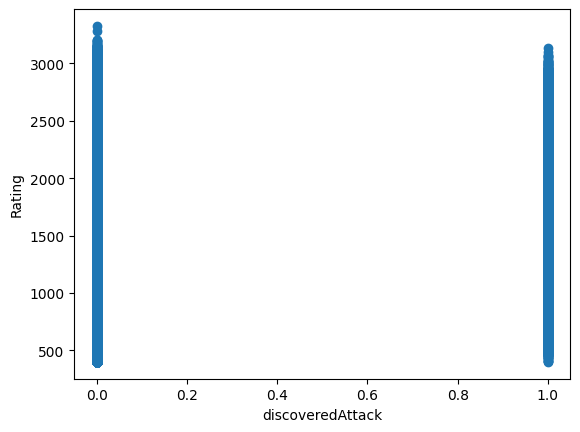

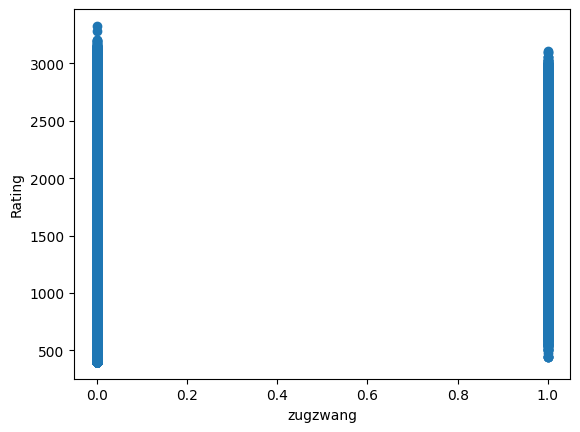

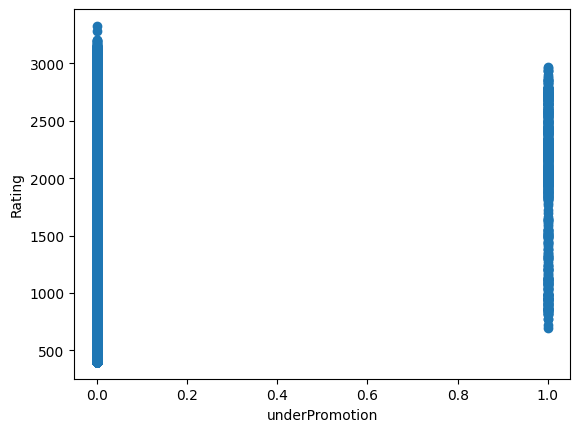

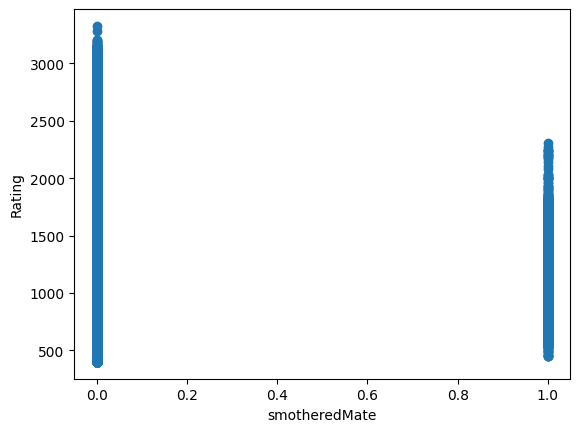

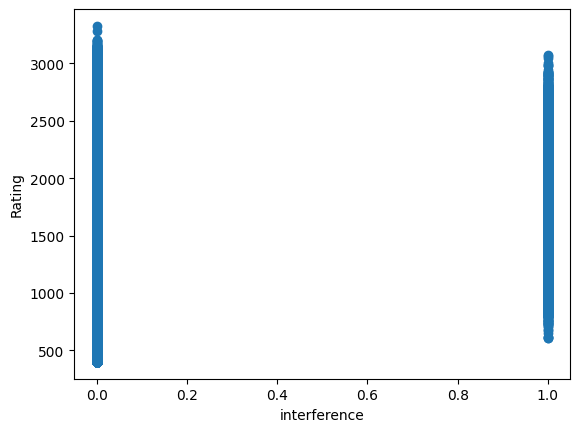

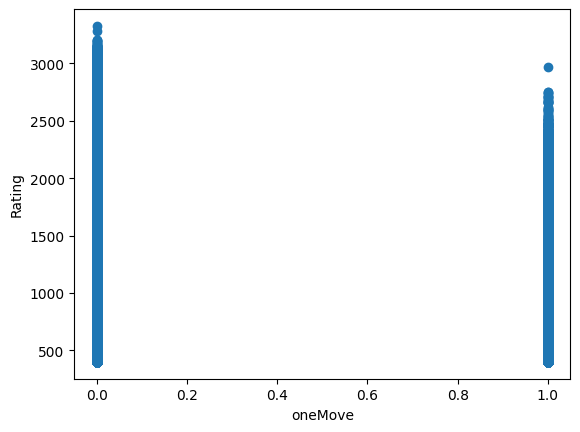

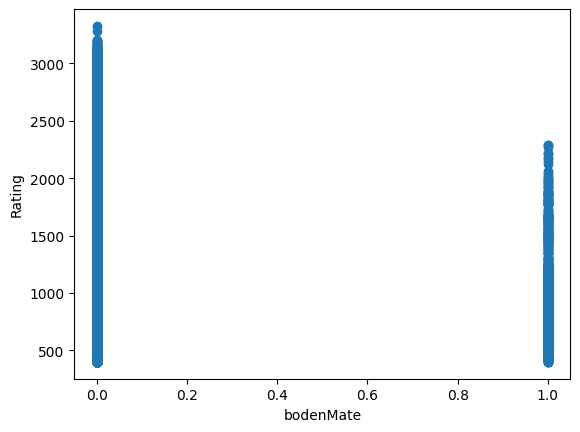

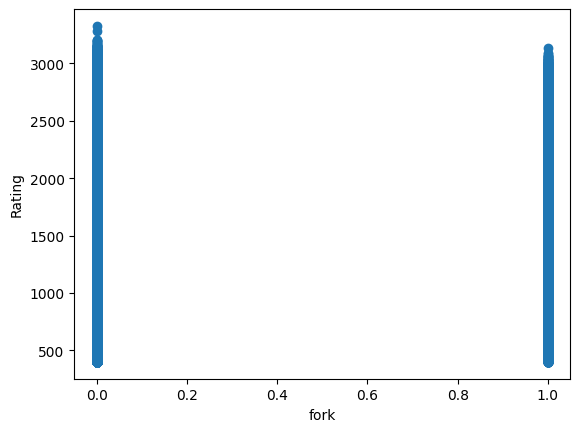

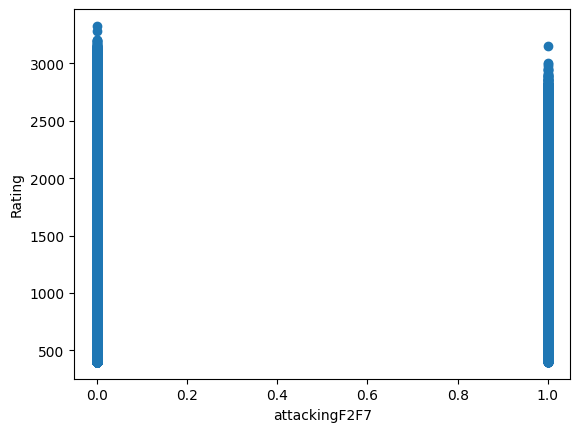

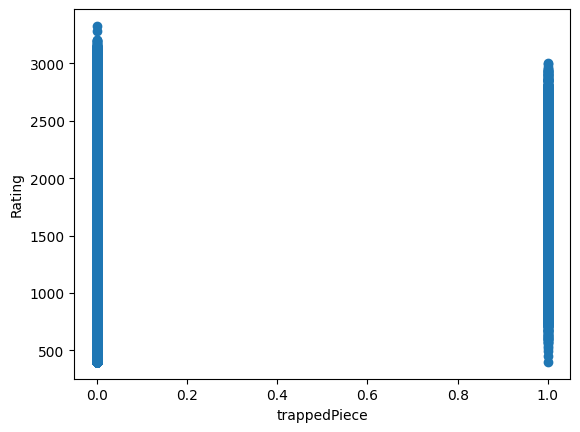

In [2]:
df.describe()

# check skew
df.skew(numeric_only=True).sort_values(key=abs, ascending=False)

# # check correlation
corr_threshold = 0.5

# calculate the correlation matrix
corr_matrix = df.corr()

# create heatmap of the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, cmap="coolwarm")

plt.show()


# corr threshold
corr_threshold = 0.5

r_matrix_filtered = corr_matrix[((corr_matrix > corr_threshold) | (corr_matrix < -corr_threshold)) & (corr_matrix != 1.0)]

corr_list = r_matrix_filtered.stack().reset_index()
corr_list.columns = ['Feature 1', 'Feature 2', 'Correlation']

# filter out the self-correlations
corr_list = corr_list[corr_list['Feature 1'] != corr_list['Feature 2']]

# sort by absolute correlation
corr_list['Correlation'] = corr_list['Correlation'].abs()
corr_list = corr_list.sort_values(by='Correlation', ascending=False)

# get every other row to avoid duplicates
corr_list = corr_list.iloc[::2]
print(corr_list)

# plot each feature against the target
for feature in df.columns:
    plt.scatter(df[feature], y)
    plt.xlabel(feature)
    plt.ylabel("Rating")
    plt.show()

# Empirical Testing

Now, we run PCA and convert into test/train data. PCA should keep 95% of the variance and the train test split should be 80/20.

We will use 100000 random records from the original dataset in order to allow the model to converge in a reasonable amount of time.

Then, we will run the above models on the produced data.

In [2]:
# implement PCA to see how many components are needed while maintaining 95% of the variance

# choose a random 100,000 samples, and their corresponding labels
df = df.sample(100000, random_state=42)
y = y[df.index]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# print number of components prior to pca
print(f"Number of features: {X_scaled.shape[1]}")

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components: {pca.n_components_}")

Number of features: 68
Number of components: 54


In [4]:
# now implement linear regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# get mean absolute error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 154444.2835766457
Mean Absolute Error: 317.0753268174042


The results of the above linear regression are: 

![Linear Regression Results](LR.png)

In [18]:
# now try with polynomial regression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_pca)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 4.3738015411966e+25
Mean Absolute Error: 482957917912.40515


The results of the above polynomial regression are:

![Polynomial Regression Results](PR.png)

In [19]:
# now try with random forest
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, max_features='sqrt')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

KeyboardInterrupt: 

The following code segment is used to find the optimal hyperparameters for Bagged SVR using GridSearchCV.

The results of the above Random Forest Regression are:

![Random Forest Regression Results](RF.png)

In [ ]:
# now try with support vector regression with grd search
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}

grid = GridSearchCV(model, param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

The results of the above grid search on a bagged SVR are:

![Bagged SVR Results](SVRGS.png)

Now, we use the generated values from the GridSearchCV to train the Bagged SVR model and predict the target values for the test data.

In [ ]:
# implement bagging for SVR
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(base_estimator=SVR(tol=1e0, cache_size=7000), n_estimators=10, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

In [ ]:
# now try an ensemble method with grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Mean Squared Error: 154746.65507538934
Mean Absolute Error: 316.1638953047325


The results of the above Gradient Boosting Regression are:

![Gradient Boosting Regression Results](BoostGS.png)

In [8]:
# now try with adaboost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV


model = AdaBoostRegressor()

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 1],
    'loss': ['linear', 'square', 'exponential']
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

{'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 200}
Mean Squared Error: 184189.97797022734
Mean Absolute Error: 355.7817436619179


The results of the above grid search on AdaBoost are:

![AdaBoost Results](ADAGS.png)

In [6]:
# XGBoost
from xgboost import XGBRegressor

model = XGBRegressor()

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
Mean Squared Error: 130979.6509394979
Mean Absolute Error: 286.36733929748533


The results of the above grid search on XGBoost are:

![XGBoost Results](XGGS.png)

In [10]:
# use a SGD regressor with grid search
from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = SGDRegressor()

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.15, 0.2, 0.25, 0.5, 0.7, 0.8, 0.85, 0.9],
    'max_iter': [1000, 2000, 4000, 5000, 10000, 20000],
    'tol': [1e-3, 1e-4, 1e-5, 1e-6],
    'penalty': ['l2', 'l1', 'elasticnet'],
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

{'alpha': 1, 'l1_ratio': 0.7, 'max_iter': 10000, 'penalty': 'elasticnet', 'tol': 0.0001}
Mean Squared Error: 159074.17539495672
Mean Absolute Error: 323.3759795569429


The results of the above grid search on SGD are:

![SGD Results](SGDGS.png)

In [ ]:
# knn regression with grid search
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'p': [1, 2]
}

knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

The results of the above grid search on KNN regression are:

![KNN Results](KNNGS.png)

# Graph Results

Now, we look at the graphs of the predicted values of the target variable against the actual values of the target variable for each of the models. 

In the following examples, we only use a a random sample of 1000 data points from the test data to plot the graphs. If a particular model takes too long to converge, then we use a smaller subset of the data.

In [13]:
# implement PCA to see how many components are needed while maintaining 95% of the variance

# choose a random 100,000 samples, and their corresponding labels
df = df.sample(10000)
y = y[df.index]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# print number of components prior to pca
print(f"Number of features: {X_scaled.shape[1]}")

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components: {pca.n_components_}")

Number of features: 68
Number of components: 52


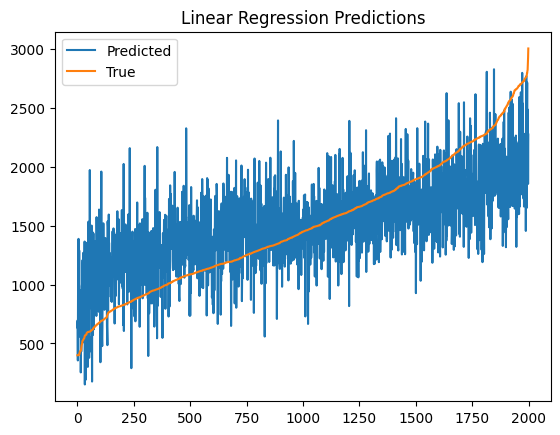

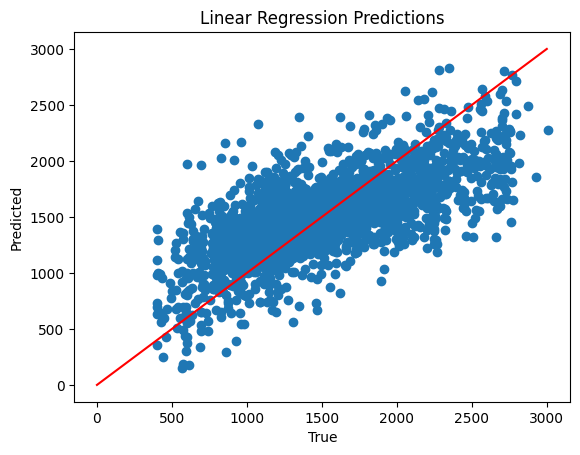

Mean Absolute Error: 323.2276965836076


In [14]:
# now implement linear regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# sort the y_test and y_pred arrays to plot them

y_test_sorted = y_test.argsort()

y_test = y_test[y_test_sorted]

y_pred = y_pred[y_test_sorted]

# remove any outliers
y_test = y_test[(y_pred >= 0) & (y_pred <= 3000)]

y_pred = y_pred[(y_pred >= 0) & (y_pred <= 3000)]

plt.title("Linear Regression Predictions")

plt.plot(y_pred, label='Predicted')

plt.plot(y_test, label='True')

plt.legend()

plt.show()

# now do a scatter plot of the predicted vs true values
plt.title("Linear Regression Predictions")
plt.scatter(y_test, y_pred)

plt.xlabel("True")

plt.ylabel("Predicted")

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

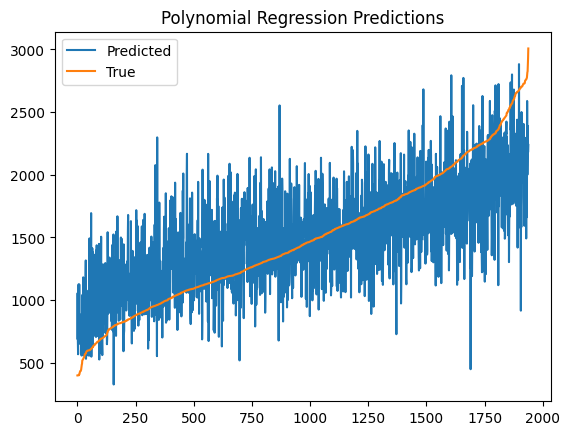

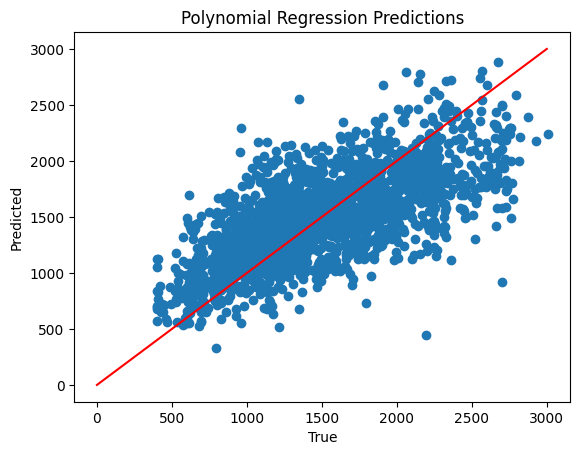

Mean Absolute Error: 306.52893972962465


In [15]:
# now implement polynomial regression with grid search

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_poly = poly.fit_transform(X_pca)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# remove any outliers
y_test = y_test[(y_pred >= 0) & (y_pred <= 3000)]

y_pred = y_pred[(y_pred >= 0) & (y_pred <= 3000)]

# sort the y_test and y_pred arrays to plot them

y_test_sorted = y_test.argsort()

y_test = y_test[y_test_sorted]

y_pred = y_pred[y_test_sorted]


plt.title("Polynomial Regression Predictions")

plt.plot(y_pred, label='Predicted')

plt.plot(y_test, label='True')

plt.legend()

plt.show()

# now do a scatter plot of the predicted vs true values
plt.title("Polynomial Regression Predictions")
plt.scatter(y_test, y_pred)

plt.xlabel("True")

plt.ylabel("Predicted")

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

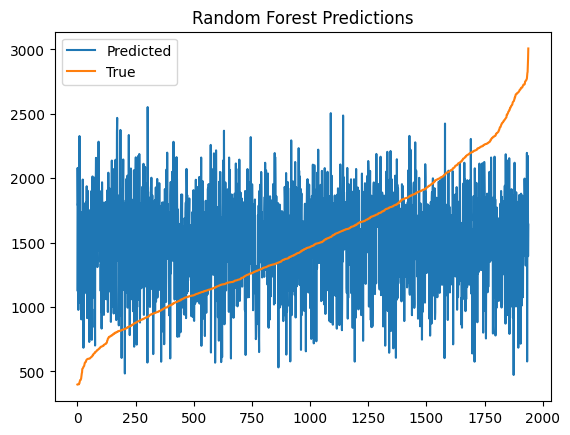

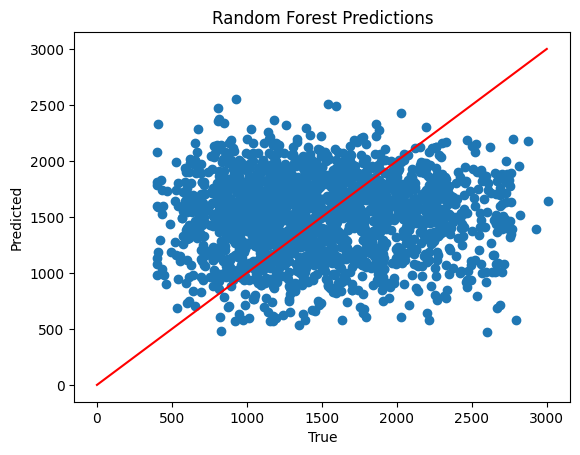

Mean Absolute Error: 516.0365458999484


In [16]:
# now try with random forest
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, max_features='sqrt')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# sort the y_test and y_pred arrays to plot them

y_test_sorted = y_test.argsort()

y_test = y_test[y_test_sorted]

y_pred = y_pred[y_test_sorted]

plt.title("Random Forest Predictions")

plt.plot(y_pred, label='Predicted')

plt.plot(y_test, label='True')

plt.legend()

plt.show()

# now do a scatter plot of the true vs predicted values
plt.title("Random Forest Predictions")
plt.scatter(y_test, y_pred)

plt.xlabel('True')

plt.ylabel('Predicted')

# draw the x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print the mean average error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

In [18]:
df = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\features.csv")

y = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\labels.csv").to_numpy().flatten()

df = df.sample(1000)

y = y[df.index]

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(df)

# print number of components prior to pca

print(f"Number of features: {X_scaled.shape[1]}")

pca = PCA(n_components=0.95)

X_pca = pca.fit_transform(X_scaled)

print(f"Number of components: {pca.n_components_}")

Number of features: 68
Number of components: 46


{'C': 1, 'gamma': 1, 'kernel': 'linear'}


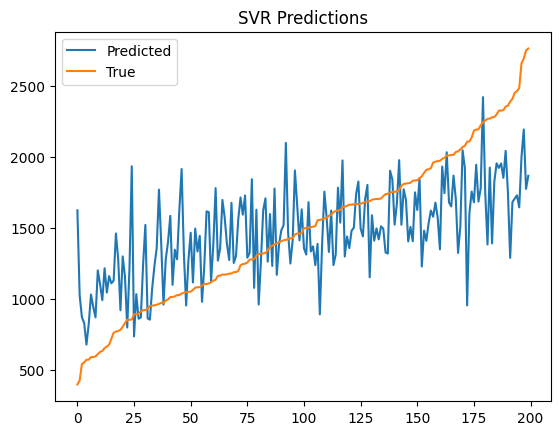

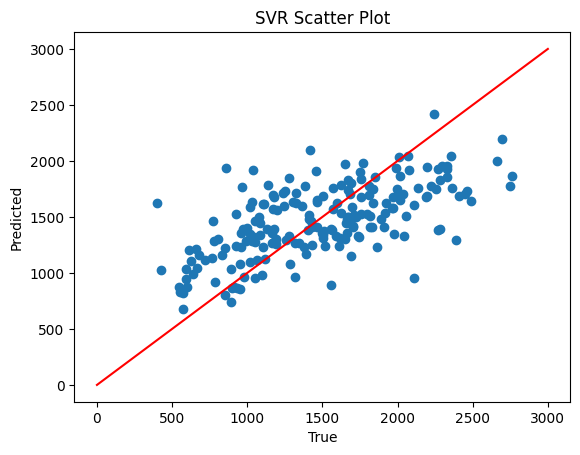

Mean Absolute Error: 330.53423742955454


In [19]:
# now try with support vector regression with grd search

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}

grid = GridSearchCV(model, param_grid, refit=True)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

# sort the y_test and y_pred arrays to plot them

y_test_sorted = y_test.argsort()

y_test = y_test[y_test_sorted]

y_pred = y_pred[y_test_sorted]

plt.title("SVR Predictions")

plt.plot(y_pred, label='Predicted')

plt.plot(y_test, label='True')

plt.legend()

plt.show()

# now do a scatter plot of the predicted vs true values
plt.title("SVR Scatter Plot")

plt.scatter(y_test, y_pred)

plt.xlabel('True')

plt.ylabel('Predicted')

# also plot x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

In [20]:
# reset the dataset to 10,000 records

df = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\features.csv")

y = pd.read_csv(r"C:\Users\prvn0\Documents\Chess\labels.csv").to_numpy().flatten()

df = df.sample(10000)

y = y[df.index]

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(df)

# print number of components prior to pca

print(f"Number of features: {X_scaled.shape[1]}")

pca = PCA(n_components=0.95)

X_pca = pca.fit_transform(X_scaled)

print(f"Number of components: {pca.n_components_}")

Number of features: 68
Number of components: 54


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


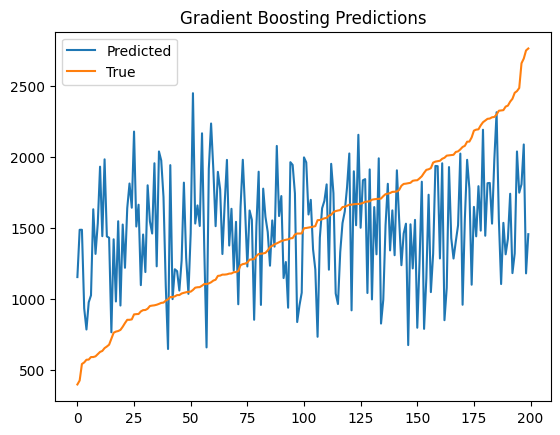

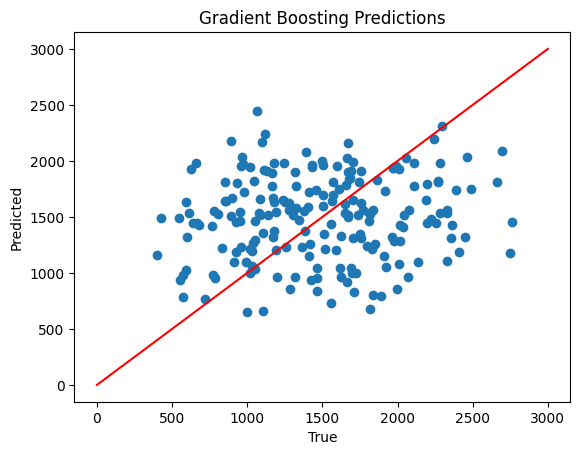

Mean Absolute Error: 508.4851949162957


In [21]:
# now try with gradient boosting

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

# sort the y_test and y_pred arrays to plot them

y_test_sorted = y_test.argsort()

y_test = y_test[y_test_sorted]

y_pred = y_pred[y_test_sorted]

plt.title("Gradient Boosting Predictions")

plt.plot(y_pred, label='Predicted')

plt.plot(y_test, label='True')

plt.legend()

plt.show()

# plot a scatter plot of the true vs predicted values
plt.title("Gradient Boosting Predictions")

plt.scatter(y_test, y_pred)

plt.xlabel('True')

plt.ylabel('Predicted')

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

{'learning_rate': 1, 'loss': 'square', 'n_estimators': 200}


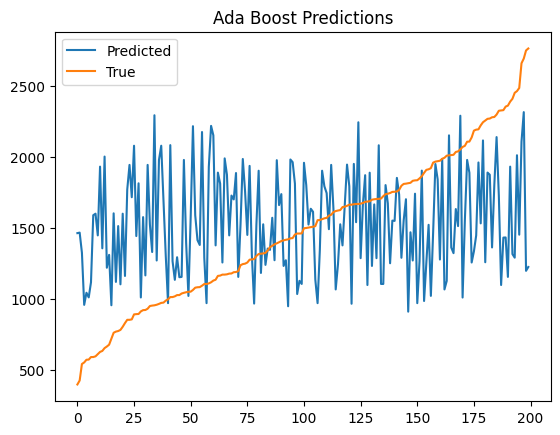

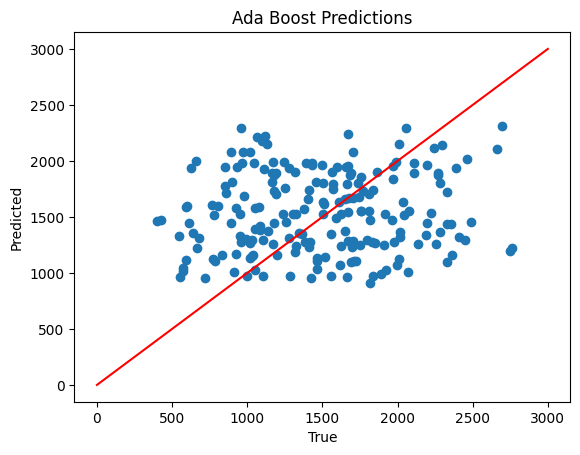

Mean Absolute Error: 500.8520629182357


In [22]:
# now try with ada boost
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor()

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 1],
    'loss': ['linear', 'square', 'exponential']
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

# sort the y_test and y_pred arrays to plot them

y_test_sorted = y_test.argsort()

y_test = y_test[y_test_sorted]

y_pred = y_pred[y_test_sorted]

plt.title("Ada Boost Predictions")

plt.plot(y_pred, label='Predicted')

plt.plot(y_test, label='True')

plt.legend()

plt.show()

# plot a scatter plot of the true vs predicted values

plt.title("Ada Boost Predictions")

plt.scatter(y_test, y_pred)

plt.xlabel('True')

plt.ylabel('Predicted')

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


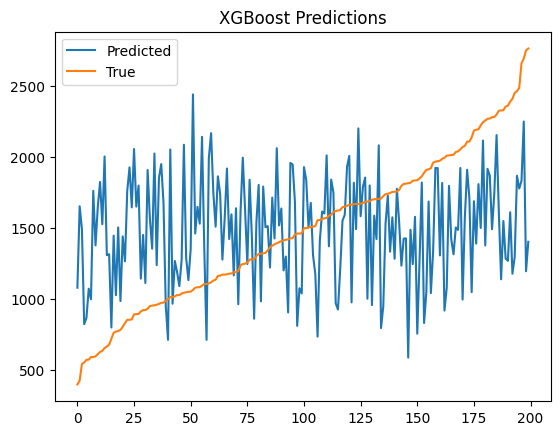

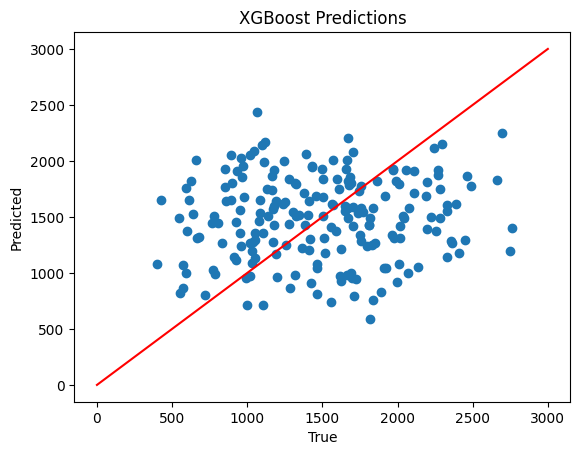

Mean Absolute Error: 514.2734942626953


In [23]:
# now try with XGBoost

from xgboost import XGBRegressor

model = XGBRegressor()

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

# sort the y_test and y_pred arrays to plot them

y_test_sorted = y_test.argsort()

y_test = y_test[y_test_sorted]

y_pred = y_pred[y_test_sorted]

plt.title("XGBoost Predictions")

plt.plot(y_pred, label='Predicted')

plt.plot(y_test, label='True')

plt.legend()

plt.show()

# plot a scatter plot of the true vs predicted values

plt.title("XGBoost Predictions")

plt.scatter(y_test, y_pred)

plt.xlabel('True')

plt.ylabel('Predicted')

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error

mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

{'alpha': 1, 'l1_ratio': 0.7, 'max_iter': 20000, 'penalty': 'elasticnet', 'tol': 1e-05}


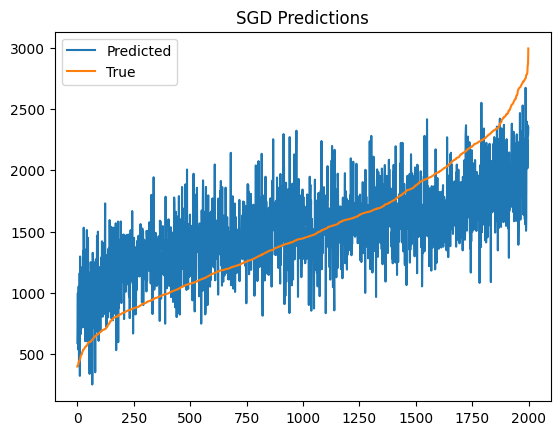

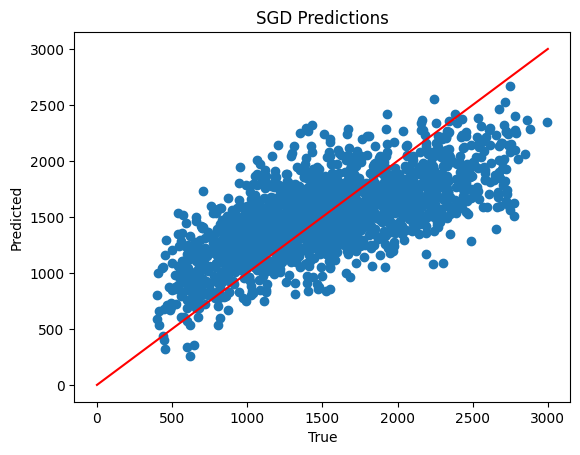

Mean Absolute Error: 316.04000737822764


In [24]:
# now try with SGD Regression

from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = SGDRegressor()

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.15, 0.2, 0.25, 0.5, 0.7, 0.8, 0.85, 0.9],
    'max_iter': [1000, 2000, 4000, 5000, 10000, 20000],
    'tol': [1e-3, 1e-4, 1e-5, 1e-6],
    'penalty': ['l2', 'l1', 'elasticnet'],
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

# sort the y_test and y_pred arrays to plot them

y_test_sorted = y_test.argsort()

y_test = y_test[y_test_sorted]

y_pred = y_pred[y_test_sorted]

plt.title("SGD Predictions")

plt.plot(y_pred, label='Predicted')

plt.plot(y_test, label='True')

plt.legend()

plt.show()

# plot a scatter plot of the true vs predicted values

plt.title("SGD Predictions")

plt.scatter(y_test, y_pred)

plt.xlabel('True')

plt.ylabel('Predicted')

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

{'metric': 'euclidean', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}


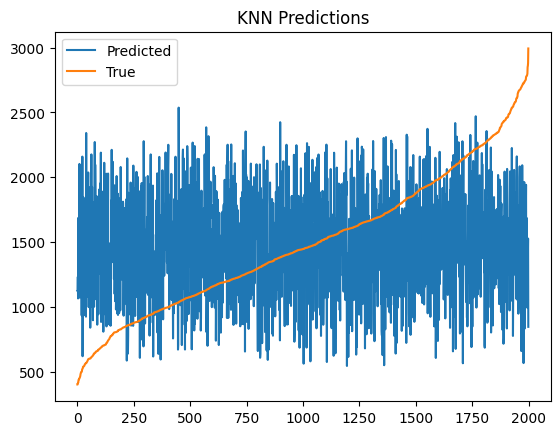

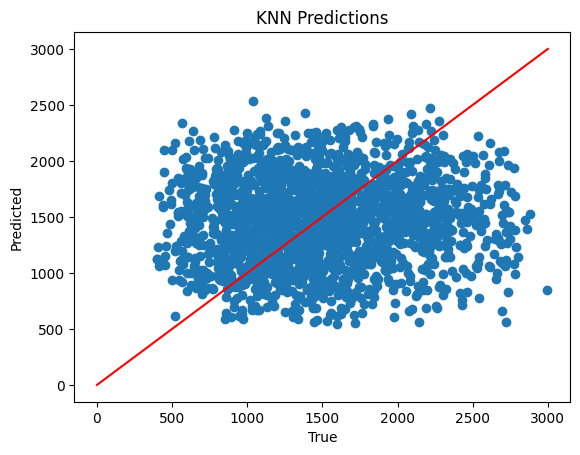

Mean Absolute Error: 522.7497292275016


In [25]:
# now try with KNN regression

from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'p': [1, 2]
}

knn = KNeighborsRegressor()

grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

# sort the y_test and y_pred arrays to plot them

y_test_sorted = y_test.argsort()

y_test = y_test[y_test_sorted]

y_pred = y_pred[y_test_sorted]

plt.title("KNN Predictions")

plt.plot(y_pred, label='Predicted')

plt.plot(y_test, label='True')

plt.legend()


plt.show()

# plot a scatter plot of the true vs predicted values

plt.title("KNN Predictions")

plt.scatter(y_test, y_pred)

plt.xlabel('True')

plt.ylabel('Predicted')

# draw x=y line
plt.plot([0, 3000], [0, 3000], color='red')

plt.show()

# print mean average error
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")